In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table

In [3]:
data_table = Table.read('peters_2015_data.fits.gz')

data_table['time_series'] = clip(data_table['time_series'] /10.,-1.,1.)
data_table['time_series'][:,:,0] =data_table['time_series'][:,:,0]*10.

randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)

randomized_inds_train = randomize_inds[0:60000]
randomized_inds_test  = randomize_inds[60000:]

In [4]:
import tensorflow as tf

def input_fn_train():
    def mapping_function(x):
        
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['secure_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,79).astype('int32'),data_table['time_series'][inds][:,:,0:6].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,80,6])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train)).repeat(None)
    dataset = dataset.shuffle(buffer_size=50000).batch(512)
    dataset = dataset.map( mapping_function )
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['secure_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,79).astype('int32'),data_table['time_series'][inds][:,:,0:6].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,80,6])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function )
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label


def input_fn_test():
    def mapping_function(x):
        
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['secure_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,79).astype('int32'),data_table['time_series'][inds][:,:,0:6].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,80,6])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function )
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label


/home/francois/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [29]:
# Build model function for time series classifier
import tensorflow.contrib.slim as slim
from tensorflow.contrib.rnn import MultiRNNCell, DropoutWrapper, LSTMCell
from tensorflow.contrib.rnn import DropoutWrapper

def _rnn_model_fn(features, labels, hidden_units, optimizer, activation_fn, normalizer_fn, dropout, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    if not is_training:
        dropout=1.0

    # Extracts the features
    input_layer = features['ts']
    length_layer = features['length']

    # Builds a recurrent neural network
    def cell(num_hidden):
        return DropoutWrapper(LSTMCell(num_hidden, name='LSTM'), output_keep_prob=dropout)

    # Defines the LSTM network
    network = MultiRNNCell([cell(n) for n in hidden_units])
    
    # Apply it to the input data
    rnn_outputs, final_state = tf.nn.dynamic_rnn(network, input_layer,
                                                 sequence_length=length_layer,
                                                 dtype=tf.float32,
                                                 scope='rnn')
    last_rnn_output = final_state[-1].h

    # Applies a last MLP for building the final prediction
    logits = slim.fully_connected(last_rnn_output, 128, scope='fc/fc_1',  activation_fn=tf.nn.elu)
    #logits = slim.fully_connected(logits, 128, scope='fc/fc_2',  activation_fn=tf.nn.elu)
    logits = tf.reshape(slim.fully_connected(logits, 1, scope='fc/fc_3',  activation_fn=None), (-1,))

    prob = tf.nn.sigmoid(logits)
    
    predictions = {'prob': prob, 'last_rnn':last_rnn_output, 'rnn':rnn_outputs}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                          export_outputs={'prob': tf.estimator.export.PredictOutput(predictions),
                                                          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(predictions)})

    # Compute and register loss function
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(labels, tf.float32), logits=logits))
    tf.losses.add_loss(loss)
    total_loss = tf.losses.get_total_loss()

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.00002).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', total_loss)

    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {"log_p": loss}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)


In [30]:
class RNNClassifier(tf.estimator.Estimator):
    """A classifier for time series data
    """

    def __init__(self,
               hidden_units,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=slim.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _rnn_model_fn(features, labels, hidden_units, optimizer, activation_fn,
                              normalizer_fn, dropout, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [31]:
# Create the model
model = RNNClassifier(hidden_units=[256,256], dropout=1.0, model_dir='/data2/rnn/logs/rnn18')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data2/rnn/logs/rnn17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4b98056978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
model.train(input_fn_train, steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/rnn/logs/rnn17/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11001 into /data2/rnn/logs/rnn17/model.ckpt.
INFO:tensorflow:loss = 0.20140392, step = 11001
INFO:tensorflow:global_step/sec: 11.7813
INFO:tensorflow:loss = 0.16361773, step = 11101 (8.489 sec)
INFO:tensorflow:global_step/sec: 11.9198
INFO:tensorflow:loss = 0.16313234, step = 11201 (8.390 sec)
INFO:tensorflow:global_step/sec: 12.0868
INFO:tensorflow:loss = 0.13259004, step = 11301 (8.273 sec)
INFO:tensorflow:global_step/sec: 11.9493
INFO:tensorflow:loss = 0.15648769, step = 11401 (8.369 sec)
INFO:tensorflow:global_step/sec: 12.0017
INFO:tensorflow:loss = 0.16520962, step = 11501 (8.332 sec)
INFO:tensorflow:global_step/sec: 11.8119
INFO

INFO:tensorflow:global_step/sec: 12.0467
INFO:tensorflow:loss = 0.1276552, step = 18701 (8.301 sec)
INFO:tensorflow:global_step/sec: 11.9991
INFO:tensorflow:loss = 0.1352369, step = 18801 (8.334 sec)
INFO:tensorflow:global_step/sec: 11.9074
INFO:tensorflow:loss = 0.1270154, step = 18901 (8.398 sec)
INFO:tensorflow:global_step/sec: 11.9624
INFO:tensorflow:loss = 0.13144955, step = 19001 (8.359 sec)
INFO:tensorflow:global_step/sec: 12.0298
INFO:tensorflow:loss = 0.15349858, step = 19101 (8.313 sec)
INFO:tensorflow:global_step/sec: 11.9404
INFO:tensorflow:loss = 0.15690878, step = 19201 (8.375 sec)
INFO:tensorflow:global_step/sec: 11.9039
INFO:tensorflow:loss = 0.13750733, step = 19301 (8.401 sec)
INFO:tensorflow:global_step/sec: 11.9757
INFO:tensorflow:loss = 0.14620163, step = 19401 (8.351 sec)
INFO:tensorflow:global_step/sec: 11.9915
INFO:tensorflow:loss = 0.12647144, step = 19501 (8.339 sec)
INFO:tensorflow:global_step/sec: 12.0476
INFO:tensorflow:loss = 0.12004439, step = 19601 (8.30

In [40]:
preds = model.predict(input_fn_test)

In [41]:
all_prob = []
for i,r in enumerate(preds):
    all_prob.append(r['prob'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/rnn/logs/rnn17/model.ckpt-21000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [42]:
all_labs = data_table['secure_label'][randomized_inds_test[:len(all_prob)]]

In [43]:
from sklearn.metrics import roc_curve

In [44]:
fpr2, tpr2, thr2 = roc_curve(all_labs, all_prob)


In [45]:
preds = model.predict(input_fn_train_test)
all_prob = []
for i,r in enumerate(preds):
    all_prob.append(r['prob'])
all_labs = data_table['secure_label'][randomized_inds_train[:len(all_prob)]]
fpr, tpr, thr = roc_curve(all_labs, all_prob)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/rnn/logs/rnn17/model.ckpt-21000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


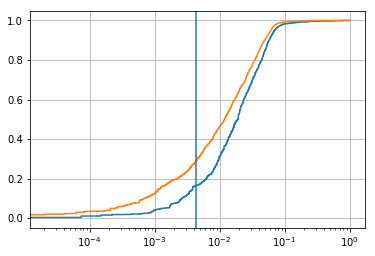

In [46]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


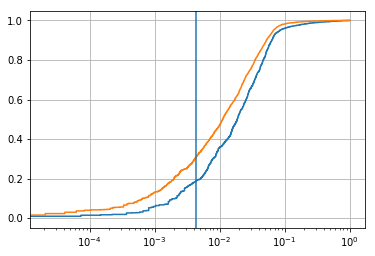

In [25]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


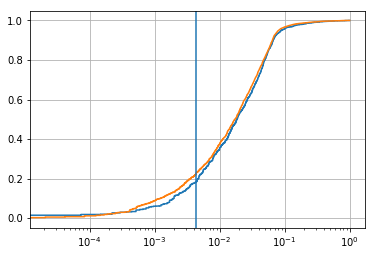

In [16]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


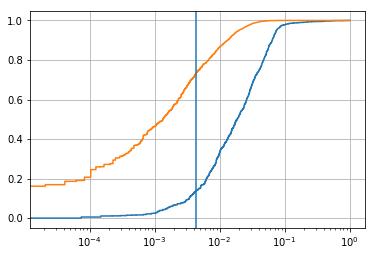

In [17]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


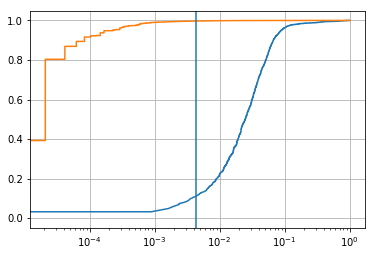

In [52]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


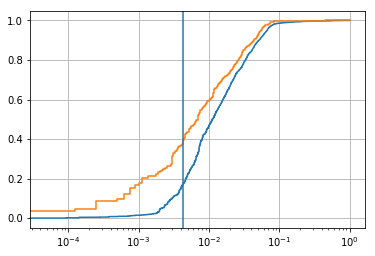

In [30]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')
axvline(0.0043)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


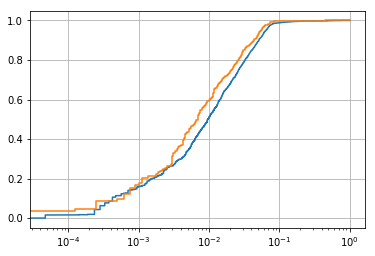

In [20]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


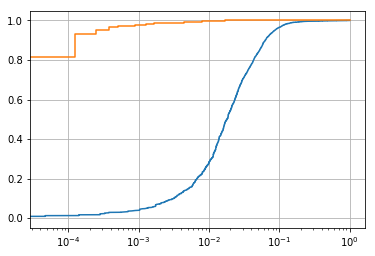

In [24]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


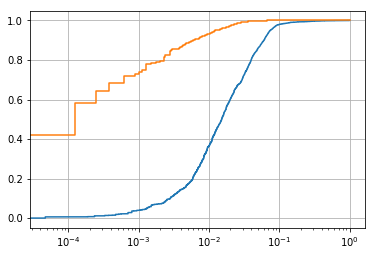

In [15]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


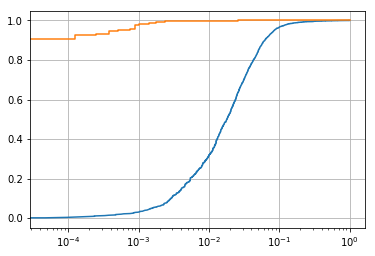

In [31]:
plot(fpr2, tpr2)
plot(fpr, tpr)
grid('on')
xscale('log')

In [27]:
where(data_table['secure_label'] != data_table['label'])

(array([ 1261,  1365,  1637,  1695,  1863,  1999,  2296,  3219,  3342,
         3387,  3434,  3476,  3499,  3689,  3739,  3776,  3975,  4014,
         4046,  4372,  4499,  4619,  4785,  5151,  5238,  5274,  5490,
         5671,  5712,  5726,  6483,  7567,  7784,  8553,  8985,  9111,
         9516,  9856,  9860, 10458, 10573, 10617, 10682, 10832, 10942,
        10979, 11078, 11386, 11524, 11905, 12102, 12132, 12271, 12316,
        12354, 12655, 12669, 13873, 15506, 16477, 16537, 16949, 17038,
        17213, 17582, 17660, 17748, 17816, 18038, 18336, 18496, 18512,
        18604, 18746, 18790, 18843, 18977, 19611, 19864, 20258, 20453,
        20494, 20676, 20680, 21628, 21656, 22270, 22356, 22390, 22978,
        23052, 23359, 23418, 23461, 23503, 23560, 23588, 23613, 23755,
        23979, 23990, 24105, 24150, 24178, 24304, 24322, 24332, 24604,
        25073, 26195, 26342, 26545, 26757, 26911, 27145, 29051, 29218,
        29408, 29482, 29621, 29690, 29896, 30003, 30085, 30107, 30496,
      

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


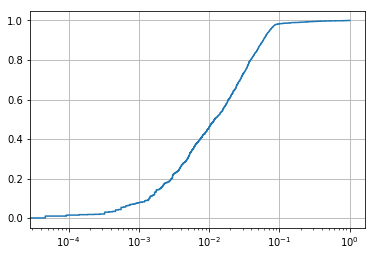

In [14]:
plot(fpr2, tpr2)
grid('on')
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


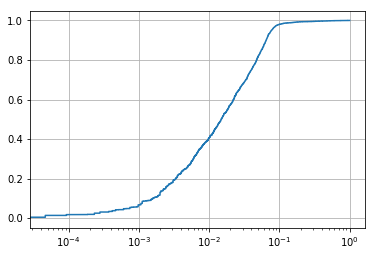

In [24]:
plot(fpr, tpr)
grid('on')
xscale('log')

In [28]:
res

{'last_rnn': array([-1.94191426e-01, -4.99837905e-01,  2.63057470e-01, -1.98005363e-01,
         4.22242403e-01, -4.32273120e-01,  4.11631465e-01, -3.92210394e-01,
        -1.86836034e-01, -3.21635529e-02, -1.24169730e-01,  2.85181820e-01,
        -1.38052881e-01,  1.19904317e-01, -3.20221297e-02,  1.18764766e-01,
        -3.56962860e-01,  2.70751297e-01, -2.68522620e-01,  3.86134356e-01,
        -2.94964522e-01,  2.37663209e-01, -1.93848953e-01,  1.89124838e-01,
        -4.02995795e-01, -2.96253741e-01,  1.03205837e-01, -2.34223053e-01,
         2.98832446e-01,  2.68726975e-01,  1.54131368e-01,  1.74046010e-01,
        -2.18293801e-01,  1.28403970e-03, -4.18276042e-02,  3.68121266e-01,
        -2.33852476e-01,  1.25344843e-01,  2.23922521e-01,  4.48367864e-01,
        -2.28569940e-01, -3.95894736e-01, -3.08292449e-01,  1.12075411e-01,
        -3.42369288e-01, -3.29866141e-01, -3.03307503e-01,  3.55020761e-01,
         1.34922564e-01,  5.79001009e-02, -3.76999110e-01, -2.22249269e-01,


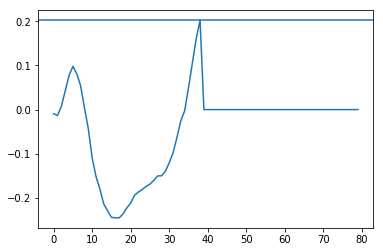

In [21]:
plot(res['rnn'][:,6])
axhline(res['last_rnn'][6])

In [12]:
res

{'last_rnn': array([ 0.12107959, -0.15827914, -0.09014755,  0.10190471,  0.1609632 ,
         0.3389828 , -0.06957211, -0.03411179, -0.16409749, -0.17293255,
        -0.01878208,  0.25724682, -0.28687295, -0.14520755, -0.01798124,
         0.02188114, -0.07879843, -0.04261052,  0.14094077, -0.11801593,
        -0.00566515, -0.14445475,  0.06198793, -0.05013452,  0.1293319 ,
        -0.37139016, -0.08932515,  0.04438834, -0.0342633 , -0.34288883,
        -0.11351605, -0.18533082,  0.0815624 ,  0.13243704,  0.16689084,
         0.07021627,  0.06119774,  0.1738819 , -0.23234719,  0.2313295 ,
         0.15466529, -0.04319582, -0.03892992,  0.18452412, -0.02355547,
        -0.06378589, -0.21451302, -0.39488068, -0.14552817,  0.1296761 ,
        -0.04741688, -0.06036036,  0.01831371,  0.01816276, -0.11241093,
         0.28653342,  0.10860398,  0.0891033 , -0.11046083,  0.08070789,
         0.26450062, -0.10058174, -0.0018898 ,  0.08117199, -0.07776216,
        -0.04086457, -0.43399945,  0.03

In [ ]:
plot(res['rnn'][:,6])

In [74]:
d, l = input_fn()

In [29]:
res['rnn'].shape

(80, 128)

In [75]:
d

{'length': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>,
 'ts': <tf.Tensor 'IteratorGetNext_1:2' shape=(?, 80, 12) dtype=float32>}

In [72]:
data_table['time_series']

0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0
0.0 .. 0.0


In [13]:
label_dataset = tf.data.Dataset.from_tensor_slices(data_table['label'].to_pandas())
ts_dataset = tf.data.Dataset.from_tensor_slices(data_table['time_series'])

AttributeError: 'Column' object has no attribute 'to_pandas'

In [16]:
label_dataset = tf.data.Dataset.from_tensor_slices(data_table['label'].astype('int32'))
ts_dataset = tf.data.Dataset.from_tensor_slices(data_table['time_series'])

TypeError: Cannot convert value dtype('>f4') to a TensorFlow DType.

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(data_table[['label', 'time_series']])

TypeError: Cannot convert value dtype([('label', '<i8'), ('time_series', '<f4', (80, 12))]) to a TensorFlow DType.